## Pipelines In SkLearn

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from brats.load_data import load_data
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
import pandas as pd 
from sklearn import svm 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from brats.load_data import load_data

# Import data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 167
The number of columns: 725


In [3]:
# Remove missing data
remove_features = data.T[data.isna().sum(axis=0) < 130]
removed_features = remove_features.T
print(f'The number of samples: {len(removed_features)}')
print(f'The number of columns: {len(removed_features.columns)}')

# Impute nans
label = removed_features['label'].to_numpy() #extract labels
features = removed_features.drop('label', axis=1) #dropped laatste kolom (labels)
replace_div = features.replace(r'#DIV/0!', 'nan', regex=True) #DIV's worden vervangen door nan 
replace_inf = replace_div.replace(np.inf, np.nan, regex=True) #inf wordt vervangen door nan

feature_names = list(replace_inf.columns) #extract feature names
imputer = KNNImputer(n_neighbors=10) #definieert functie K-nearest neighbor imputer
clean_data = imputer.fit_transform(replace_inf) #alle nan's worden vervangen op basis van k-NN imputer

The number of samples: 167
The number of columns: 705


In [4]:
#convert labels to true and false
labels = label=='GBM'

In [5]:
## Pipelines Creation
## 1. Data Preprocessing by using Standard Scaler
## 2. Reduce Dimension using PCA
## 3. Apply  Classifier

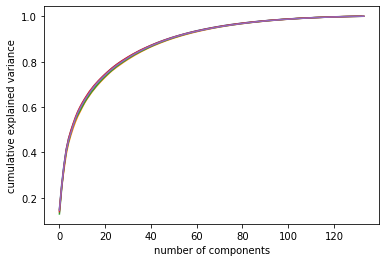

In [6]:
# check # components for PCA
rskf = StratifiedKFold(n_splits=5)
for train_index, test_index in rskf.split(features, label):
    data_train, data_test = clean_data[train_index], clean_data[test_index]
    label_train, label_test = labels[train_index], labels[test_index]
    #Standard Scaling
    scaler = StandardScaler().fit(data_train)
    data_train = scaler.transform(data_train)
    data_test = scaler.transform(data_test)
    #Train on trainingsdata and apply PCA
    # pca = PCA(n_components=j).fit(data_train)
    # train_array = pca.transform(data_train)
    # test_array = pca.transform(data_test)
    pca = PCA().fit(data_train)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

In [7]:
pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=40)),
                     ('lr_classifier',LogisticRegression(random_state=0))])

In [8]:
pipeline_dt=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=20)),
                     ('dt_classifier',DecisionTreeClassifier())])

In [9]:
pipeline_randomforest=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=20)),
                     ('rf_classifier',RandomForestClassifier())])

In [10]:
pipeline_quadratic=Pipeline([('scalar4',StandardScaler()),
                     ('pca4',PCA(n_components=20)),
                     ('qda_classifier',QuadraticDiscriminantAnalysis())])

In [11]:
pipeline_gauss=Pipeline([('scalar5',StandardScaler()),
                     ('pca5',PCA(n_components=20)),
                     ('qnb_classifier',GaussianNB())])

In [12]:
pipeline_sgd=Pipeline([('scalar6',StandardScaler()),
                     ('pca6',PCA(n_components=20)),
                     ('sgd_classifier',SGDClassifier())])

In [13]:
pipeline_knn=Pipeline([('scalar7',StandardScaler()),
                     ('pca7',PCA(n_components=20)),
                     ('knn_classifier',KNeighborsClassifier())])

In [17]:
## LEts make the list of pipelines
pipelines = [pipeline_dt, pipeline_randomforest, pipeline_quadratic, pipeline_gauss, pipeline_sgd, pipeline_knn]

In [18]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [21]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Decision Tree', 1: 'RandomForest', 2: 'Quadratic Discriminant Analysis', 3: 'Gaussian NB', 4: 'Stochastic Gradient Descent', 5: 'KNeighbors classifier'}


rskf = StratifiedKFold(n_splits=5) #ik heb random state verwijderd, daardoor worden steeds dezelfde r splits gemaakt

for train_index, test_index in rskf.split(features, label):
	data_train, data_test = clean_data[train_index], clean_data[test_index]
	label_train, label_test = labels[train_index], labels[test_index]
	for pipe in pipelines:
		pipe.fit(data_train, label_train)

In [22]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(data_test,label_test)))

Decision Tree Test Accuracy: 0.5454545454545454
RandomForest Test Accuracy: 0.8787878787878788
Quadratic Discriminant Analysis Test Accuracy: 0.8181818181818182
Gaussian NB Test Accuracy: 0.696969696969697
Stochastic Gradient Descent Test Accuracy: 0.8484848484848485
KNeighbors classifier Test Accuracy: 0.9090909090909091


In [23]:
for i,model in enumerate(pipelines):
    if model.score(data_test,label_test)>best_accuracy:
        best_accuracy=model.score(data_test,label_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy:KNeighbors classifier


## Pipelines Perform Hyperparameter Tuning Using Grid SearchCV

In [24]:
from sklearn.model_selection import GridSearchCV

In [26]:
# Create a pipeline
pipe = Pipeline([("classifier", KNeighborsClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": [5, 10, 20, 50],
                 "classifier__weights": ['uniform', 'distance']
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2'],
                 "classifier__C": np.logspace(0, 4, 10),
                 "classifier__solver":['newton-cg','saga','sag','liblinear'] ##This solvers don't allow L1 penalty
                 },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(data_train,label_train)

In [27]:
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(data_test, label_test))

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=5, max_leaf_nodes=2,
                                        min_samples_leaf=10,
                                        n_estimators=10))])
The mean accuracy of the model is: 0.9393939393939394


## MakePipelines In SKLearn

In [31]:
from sklearn.pipeline import make_pipeline

In [32]:
# Create a pipeline
pipe = make_pipeline((RandomForestClassifier()))
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"randomforestclassifier": [RandomForestClassifier()],
                 "randomforestclassifier__n_estimators": [10, 100, 1000],
                 "randomforestclassifier__max_depth":[5,8,15,25,30,None],
                 "randomforestclassifier__min_samples_leaf":[1,2,5,10,15,100],
                 "randomforestclassifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(data_train,label_train)

In [33]:
best_model.score(data_test,label_test)

0.9393939393939394